# Preprocess the divided *Train* and *Test* Dataset

### GPU Availability Test

In [1]:
import tensorflow as tf
print("\n\nNum GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-07-14 08:14:24.543098: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 08:14:24.559412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752480864.578795    3078 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752480864.584276    3078 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 08:14:24.602548: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr



Num GPUs Available:  1


## Dataset

In [ ]:
import pandas as pd

In [19]:
train_df = pd.read_csv("Prepared-Data/train-data.csv")
train_df

,Text,Ham,Spam
0,Give one miss from that number please,1,0
1,Hi Princess! Thank you for the pics. You are v...,1,0
2,New TEXTBUDDY Chat 2 horny guys in ur area 4 j...,0,1
3,URGENT! We are trying to contact U. Todays dra...,0,1
4,Dont give a monkeys wot they think and i certa...,1,0
...,...,...,...
2555,"Machan you go to gym tomorrow, i wil come lat...",1,0
2556,Rising Star: Rohit Ferro (NSE/BSE) CMP 50 TRGT...,0,1
2557,URGENT! Your Mobile number has been awarded wi...,0,1
2558,Wat so late still early mah. Or we juz go 4 di...,1,0


## Preprocessing

In [62]:
from tensorflow.keras.layers import TextVectorization

In [63]:
train_df.columns

Index(['Text', 'Ham', 'Spam'], dtype='object')

In [64]:
# Ham and Spam array values
op_vals = train_df[train_df.columns[1:]].values
op_vals

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]])

In [65]:
X = train_df["Text"]
y = op_vals

In [66]:
# Getting the maximum vocab length
words_list = " ".join(train_df["Text"]).split()
vocab = set(words_list)
print("Vocab Length: ", len(vocab))

Vocab Length:  14243


In [67]:
# So assigning around 15000 features (greater than vocab)
MAX_FEATURES = 15000
MAX_LEN = 107

In [68]:
vectorizer = TextVectorization(
    max_tokens = MAX_FEATURES,
    output_mode = 'int',
    output_sequence_length= MAX_LEN,
)

In [69]:
# Teach vectorizer our vocabulary
vectorizer.adapt(X.values)

In [70]:
len(vectorizer.get_vocabulary())

9580

In [71]:
vectorizer("This notebook is written by manas")

<tf.Tensor: shape=(107,), dtype=int64, numpy=
array([  31, 5730,   14,    1,   64,    1,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])>

In [72]:
vectorized_text = vectorizer(X.values)
vectorized_text

<tf.Tensor: shape=(2560, 107), dtype=int64, numpy=
array([[ 159,   80,  173, ...,    0,    0,    0],
       [ 184,  682,  570, ...,    0,    0,    0],
       [  41, 4309,  186, ...,    0,    0,    0],
       ...,
       [ 141,    8,   43, ...,    0,    0,    0],
       [ 257,   47,  430, ...,    0,    0,    0],
       [2057, 5864, 1595, ...,    0,    0,    0]])>

In [73]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps prevent bottle necks

In [74]:
batch_X, batch_y = dataset.as_numpy_iterator().next()
dataset.as_numpy_iterator().next()

(array([[ 141,   45,   23, ...,    0,    0,    0],
        [5948,    6,   95, ...,    0,    0,    0],
        [   5,  700, 6433, ...,    0,    0,    0],
        ...,
        [  36,  681,   20, ...,    0,    0,    0],
        [ 141,    8,   43, ...,    0,    0,    0],
        [  42,    3,   66, ...,    0,    0,    0]]),
 array([[0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0]]))

In [75]:
# Dividing for train and validation
train = dataset.take(int(len(dataset)*.9))
validation = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

## Building Bidirectional LSTM

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Embedding, Dense

In [81]:
model = Sequential()

# Embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))

# TanH function works better with GPU
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# OUTPUT layer
model.add(Dense(2, activation='sigmoid'))

In [82]:
model.compile(loss="BinaryCrossentropy", optimizer='Adam')

In [83]:
history = model.fit(train, epochs=20, validation_data=validation)

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.5031 - val_loss: 0.0794
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0864 - val_loss: 0.0452
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0631 - val_loss: 0.0377
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0190 - val_loss: 9.6770e-04
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0058 - val_loss: 3.5358e-04
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0030 - val_loss: 2.0756e-04
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 9.6142e-04 - val_loss: 5.4395e-05
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 4.6714e-05 - val_loss: 3.1675e-05
Epoch 9/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.3534e-05 - val_loss: 1.6926e-05
Epoch 10/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.2921e-05 - val_loss: 4.9665e-06
Epoch 11/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8.5965e-06 - val_loss: 

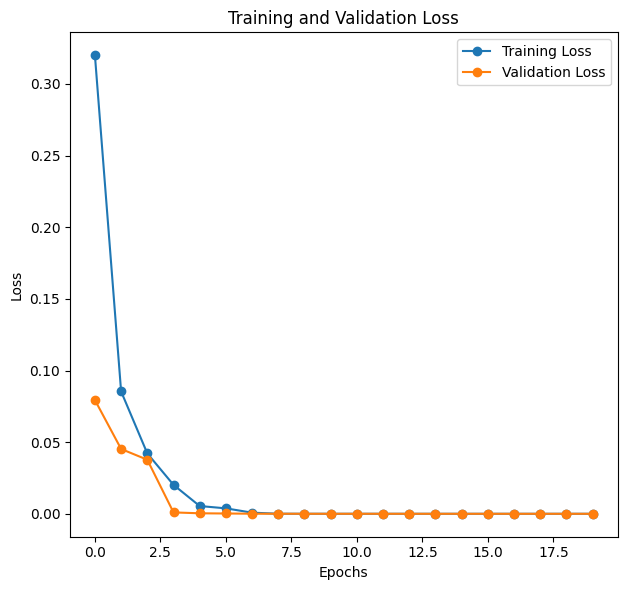

In [85]:
import matplotlib.pyplot as plt
history_dict = history.history

# Extract values
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# If you have additional metrics (like accuracy)
if 'accuracy' in history_dict:
    train_accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy (if available)
if 'accuracy' in history_dict:
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy', marker='o')
    plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

## Saving Vectorizer model and Prediction Model

In [110]:
tf.keras.models.save_model(vectorizer, "Models/Vectorizer-Models/spam_ham_text_vectorizer.keras")


model.save("Models/Predictive-Models/spam_ham_BiLstm.keras")
model.save_weights("Models/Predictive-Models/spam_ham_BiLstm.weights.h5")

 Preprocessing and Training Done!!

## Small test

In [113]:
import numpy as np

In [119]:
def predict_text_sms(sms: str) -> str:
    result_map = {
        0: "Ham",
        1: "Spam"
    }
    vec = vectorizer(sms)
    pred = model.predict(np.expand_dims(vec, 0))
    
    return result_map[np.argmax(pred)] 

In [120]:
predict_text_sms("Hey there how are you??")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


'Ham'

In [122]:
predict_text_sms("You have won 2 lakh rupees lottery!!! to claim it whatsapp on this number!!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


'Spam'

Data Preprocessing and Model Building is Done!!